In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection
from tool import local_max, noise, circle, outliers, gaussian, make_histogram_projection, extract_data, get_k_equipartition, gaussian_analysis
import numpy.random as rand
from scipy.optimize import curve_fit
from scipy import integrate
import scipy.constants as cnst
from glob import glob

## Generate nm:px Conversion Ratio

[32.1598 32.2925 32.5363 ... 32.8029 32.8942 32.8164]

pixel sep = 236.8 +/- 0.98 [pixels]
nm/px = 42.23 +/- 0.175 [nm/px]
px/um = 23.68 +/- 0.098 [px/um]


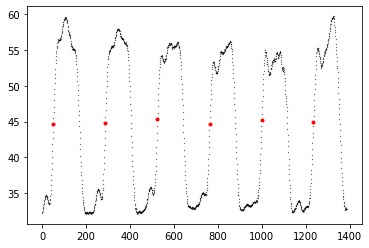

In [2]:
data = np.genfromtxt("/work/data/Calibration2.txt",delimiter='\t', skip_header = 1).T
x_dat = data[0]
y_dat = data[1]
print(y_dat)

maxes, idx = local_max(-np.abs(y_dat-45),N=90)

plt.plot(x_dat,y_dat,"k.",markersize=0.5)
plt.plot(x_dat[idx][::2],y_dat[idx][::2],"r.")
pixel_seperation = np.mean(np.diff(x_dat[idx][::2])) # separation in px
uncert_px = np.std(np.diff(x_dat[idx][::2]))
um_per_px = 10/pixel_seperation
um_per_px_err = (uncert_px/pixel_seperation)*um_per_px

dec = 3
print("\npixel sep =",np.around(pixel_seperation,dec),"+/-",np.around(uncert_px,dec),"[pixels]")

print("nm/px =",np.around(um_per_px*1000,dec),"+/-",np.around(um_per_px_err*1000,dec),"[nm/px]")

print("px/um =",np.around(um_per_px**(-1),dec),"+/-",np.around((um_per_px_err/um_per_px)*um_per_px**(-1),dec),"[px/um]")


## Import Sample D Raw Data

outliers found
30.914822635135135
[]


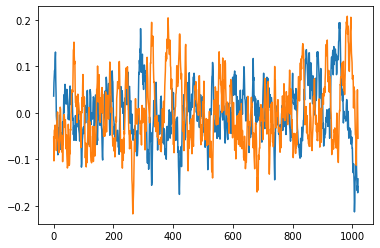

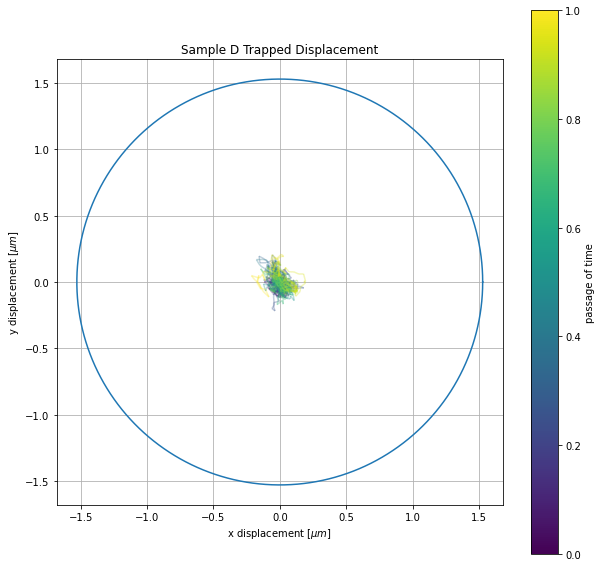

In [3]:
filename = "/work/data/SampleD_trapped2.txt"
rad_px, x_px, y_px = np.genfromtxt(filename,delimiter = "\t",unpack=True)
x_px, y_px, idx = outliers(x_px, y_px, max_movement = 1.6)
if len(idx) != 0:
    print('outliers found')
rad_px = np.array([rad_px[i] for i in range(len(x_px)) if i not in idx])

rad_dat = rad_px[:2000]*um_per_px
x_dat = x_px[:2000]*um_per_px
y_dat = y_px[:2000]*um_per_px
x_ave = np.mean(x_dat)
y_ave = np.mean(y_dat)

print(np.min(x_dat))

print(np.argwhere(np.isnan(x_dat)))
rad_arr = rad_dat
x = x_dat-x_ave
y = y_dat-y_ave
plt.plot(x,label=r"x position")
plt.plot(y,label=r"y position")
plt.xlabel("Perportional to Time (1/fps)")
plt.ylabel("Position Relative to Mean [$\mu$m]")
plt.show()

fig, ax = plt.subplots(figsize = (10,10))

#no idea how this formatting works
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1) 

lc = LineCollection(segments, cmap='viridis', alpha = 0.3)
lc.set_array(np.linspace(0,1,len(x)))
line = ax.add_collection(lc)


thetas = np.linspace(0, 2*np.pi, 200)
circle_x, circle_y = circle(thetas, radius = np.mean(rad_dat))
fig.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax,label = "passage of time")
ax.grid()
ax.plot(circle_x, circle_y)
ax.set(ylabel = "y displacement [$\mu m$]", xlabel = "x displacement [$\mu m$]", title = "Sample D Trapped Displacement",
        aspect = 'equal')

        

x_trapped = x
y_trapped = y
rad_trapped = rad_arr


27.055320945945944
[]
with drift removed std x = 0.0388264215111741
with drift removed std y = 0.04754312345812869


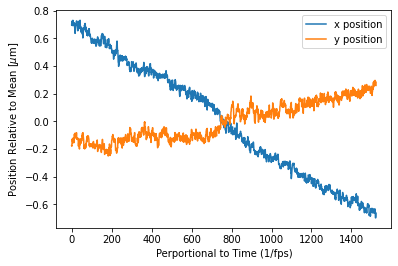

[Text(0, 0.5, 'y displacement [$\\mu m$]'),
 Text(0.5, 0, 'x displacement [$\\mu m$]'),
 Text(0.5, 1.0, 'Sample D Trapped Displacement'),
 None]

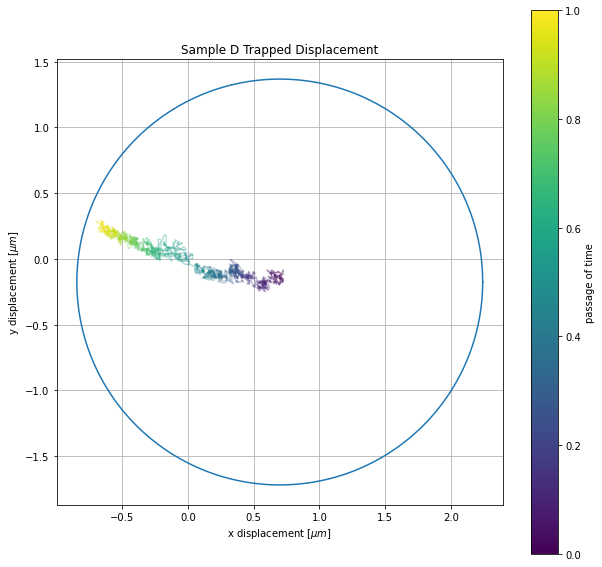

In [78]:
filename = "/work/data/SampleD_stuckBead4.txt"
rad_px, x_px, y_px = np.genfromtxt(filename,delimiter = "\t",unpack=True)
x_px, y_px, idx = outliers(x_px, y_px)
if len(idx) != 0:
    print('outliers found')
rad_px = np.array([rad_px[i] for i in range(len(x_px)) if i not in idx])

rad_dat = rad_px*um_per_px
x_dat = x_px*um_per_px
y_dat = y_px*um_per_px
x_ave = np.mean(x_dat)
y_ave = np.mean(y_dat)

print(np.min(x_dat))

print(np.argwhere(np.isnan(x_dat)))
rad_arr = rad_dat
x = x_dat-x_ave
y = y_dat-y_ave

fitx = np.polynomial.Polynomial.fit(np.arange(0,len(x),1),x, deg = 1)
fity = np.polynomial.Polynomial.fit(np.arange(0,len(x),1),y, deg = 1)
x_no_drift = x - fitx(np.arange(0,len(x),1))
y_no_drift = y - fity(np.arange(0,len(x),1))

print(f"with drift removed std x = {np.std(x_no_drift)}")
print(f"with drift removed std y = {np.std(y_no_drift)}")

plt.plot(x,label=r"x position")
plt.plot(y,label=r"y position")

plt.xlabel("Perportional to Time (1/fps)")
plt.ylabel("Position Relative to Mean [$\mu$m]")
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize = (10,10))

#no idea how this formatting works
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1) 

lc = LineCollection(segments, cmap='viridis', alpha = 0.3)
lc.set_array(np.linspace(0,1,len(x)))
line = ax.add_collection(lc)


thetas = np.linspace(0, 2*np.pi, 200)
circle_x, circle_y = circle(thetas, radius = np.mean(rad_dat))
circle_x += x[0]
circle_y += y[0]

fig.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax,label = "passage of time")
ax.grid()
ax.plot(circle_x, circle_y)
ax.set(ylabel = "y displacement [$\mu m$]", xlabel = "x displacement [$\mu m$]", title = "Sample D Trapped Displacement",
        aspect = 'equal')

outliers found
1902
25.54945101351351


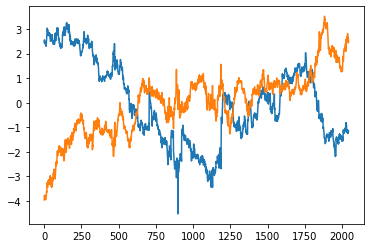

[Text(0, 0.5, 'y displacement [$\\mu m$]'),
 Text(0.5, 0, 'x displacement [$\\mu m$]'),
 Text(0.5, 1.0, 'Sample D Trapped Displacement'),
 None]

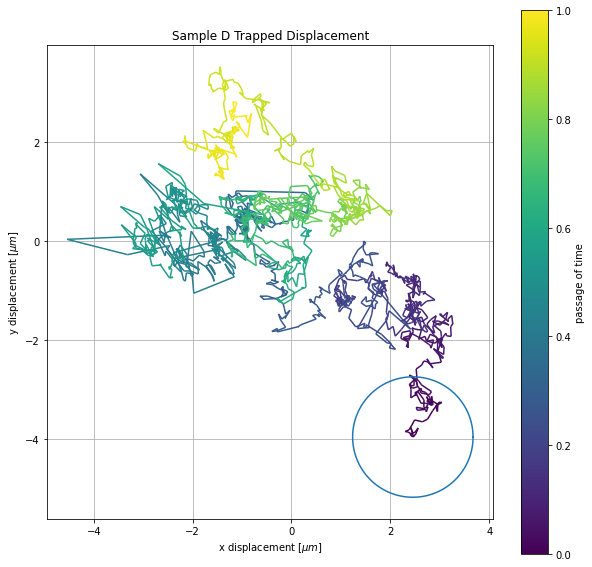

In [5]:
filename = "/work/data/SampleD_loneRandomWalk.txt"
rad_px, x_px, y_px = np.genfromtxt(filename,delimiter = "\t",unpack=True)
x_px, y_px, idx = outliers(x_px, y_px)
if len(idx) != 0:
    print('outliers found')
rad_px = np.array([rad_px[i] for i in range(len(x_px)) if i not in idx])
print(len(rad_px))

rad_dat = rad_px*um_per_px
x_dat = x_px*um_per_px
y_dat = y_px*um_per_px
x_ave = np.mean(x_dat)
y_ave = np.mean(y_dat)

print(np.min(x_dat))

rad_arr = rad_dat
x = x_dat-x_ave
y = y_dat-y_ave
plt.plot(x,label=r"x position")
plt.plot(y,label=r"y position")
plt.xlabel("Perportional to Time (1/fps)")
plt.ylabel("Position Relative to Mean [$\mu$m]")
plt.show()

fig, ax = plt.subplots(figsize = (10,10))

#no idea how this formatting works
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1) 

lc = LineCollection(segments, cmap='viridis')
lc.set_array(np.linspace(0,1,len(x)))
line = ax.add_collection(lc)


thetas = np.linspace(0, 2*np.pi, 200)
circle_x, circle_y = circle(thetas, radius = np.mean(rad_dat))
circle_x += x[0]
circle_y += y[0]
fig.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax,label = "passage of time")
ax.grid()
ax.plot(circle_x, circle_y)
ax.set(ylabel = "y displacement [$\mu m$]", xlabel = "x displacement [$\mu m$]", title = "Sample D Trapped Displacement",
        aspect = 'equal')

### Autocorrelation Analysis

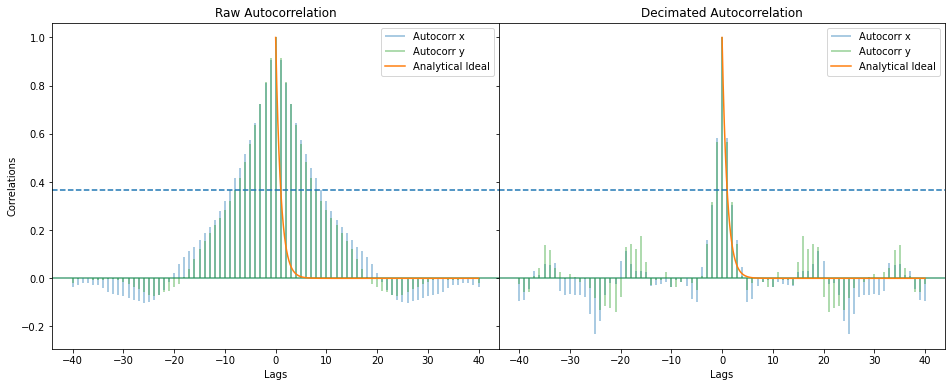

test


In [31]:
fig = plt.figure(figsize = (16,6))
gs = fig.add_gridspec(1,2, hspace=0,wspace = 0)
ax1, ax2 = gs.subplots(sharex=True, sharey=True)
#fig.suptitle('Autocorrelation for Decimation')

# Plot experimental autocorrelation
# I dont know if these are the values we want tho
k = 1
gamma = 1
tau_0 = k/gamma
deltaT = 0.01
D = 1 #= kB T / gamma

x = x_trapped
y = y_trapped

maxLagVal = 40
model = np.linspace(1e-5,maxLagVal,10000)

ax1.acorr(x, maxlags = maxLagVal,label = "Autocorr x",color = "C0",alpha = 0.5)
ax1.acorr(y, maxlags = maxLagVal,label = "Autocorr y",color = "C2",alpha = 0.5)
ax1.plot(model,D*tau_0*np.exp(-np.abs(model)/tau_0),label = "Analytical Ideal",color = "C1")
ax1.axhline(1/np.e,linestyle = "dashed")
ax1.set(title = "Raw Autocorrelation", xlabel = 'Lags', ylabel = "Correlations")
ax1.legend()


# Decimate data
interval = 5
x_dec = x[::interval]
y_dec = y[::interval]
#lol waht happened?
# idk did it shut down?

# Plot decimated autocorrelation
ax2.acorr(x_dec, maxlags = maxLagVal,label = "Autocorr x",color = "C0",alpha = 0.5)
ax2.acorr(y_dec, maxlags = maxLagVal,label = "Autocorr y",color = "C2",alpha = 0.5)
ax2.plot(model,D*tau_0*np.exp(-np.abs(model)/tau_0),label = "Analytical Ideal",color = "C1")
ax2.axhline(1/np.e,linestyle = "dashed")
ax2.legend()
ax2.set(title = "Decimated Autocorrelation",xlabel = "Lags")

plt.show()
print("test")

In [7]:
mean_x = np.mean(x)
mean_y = np.mean(y)

r = np.sum((x-mean_x)*(y-mean_y))/(np.sqrt(np.sum((x - mean_x)**2))*np.sqrt(np.sum((y - mean_y)**2)))

print(f"r = {r}")

r = -0.35539180513289376


### Equipartition Method - Determining k

In [8]:
# Eq 2) U = kx^2/2
# Eq 28) 1/2 k var(disp_from_mean) = 1/d k_b T
# therefore: k = k_b T / var(disp_from_mean)

k_b = cnst.Boltzmann # m^2 kg s-2 K-1
T = 298 # K
var_x = np.var(x_dec/(10**6))
var_y = np.var(y_dec/(10**6))

k_x = k_b*T/(var_x)
k_y = k_b*T/(var_y)

print("Spring Constant in x =",k_x,"[N/m]")
print("Spring Constant in y =",k_y,"[N/m]")

Spring Constant in x = 1.2299661262233275e-06 [N/m]
Spring Constant in y = 8.545605291665331e-07 [N/m]


# Gaussian fit method

Via Gaussian Fit Method
k_x = 0.47673099389591145
k_y = 0.4613404391906798
Via equipartition
k_x = 0.4645644598982524
k_y = 0.453670319026367


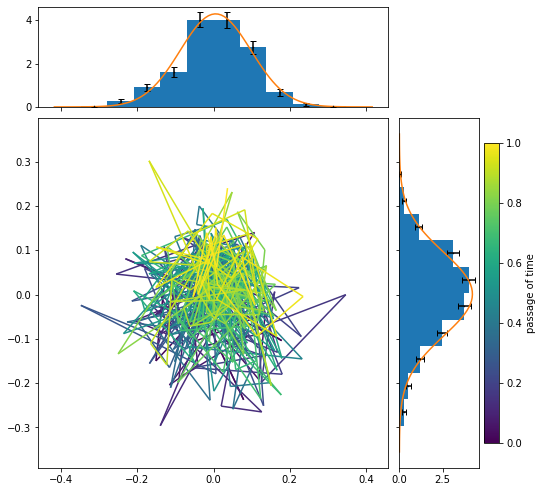

In [14]:
filename = "/work/data/SampleD_trapped1.txt"
ret = extract_data(filename)


analysis2 = make_histogram_projection(ret.x_dec, ret.y_dec, printBool = False)
print(f"Via Gaussian Fit Method\nk_x = {analysis2.k_x}\nk_y = {analysis2.k_y}")

k_x, k_y = get_k_equipartition(ret.x_dec, ret.y_dec)
print(f"Via equipartition\nk_x = {k_x}\nk_y = {k_y}")

Via Gaussian Fit Method
k_x = 0.4726083417652418
k_y = 0.19695139720245505
Via equipartition
k_x = 0.5407166890915005
k_y = 0.20774767451526735


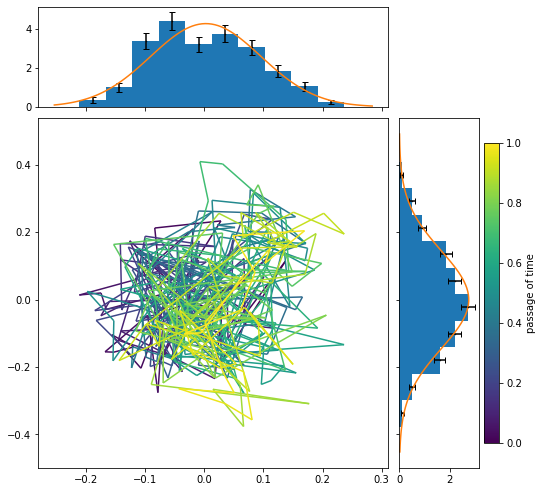

In [10]:
filename = '/work/data/reproducibility/SampleD_reproducibility1_data.txt'
ret = extract_data(filename)


analysis2 = make_histogram_projection(ret.x_dec, ret.y_dec, printBool = False)
print(f"Via Gaussian Fit Method\nk_x = {analysis2.k_x}\nk_y = {analysis2.k_y}")

k_x, k_y = get_k_equipartition(ret.x_dec, ret.y_dec)
print(f"Via equipartition\nk_x = {k_x}\nk_y = {k_y}")

Gaussian Method
kx = 0.8846446563808658 p/m 0.30195943016421267
ky = 0.7740975646725746 p/m 0.21502657228829133

Equipartition Method
kx = 0.8026274454717932 p/m 0.293693067280131
ky = 0.7815320215146933 p/m 0.22558044893494494


Text(0.5, 1.0, 'Repeatability Measurments from Sample D')

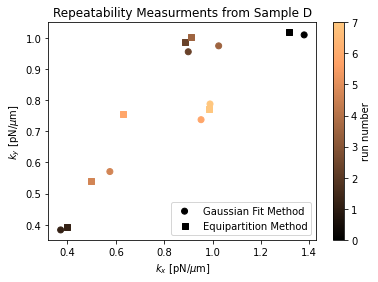

In [106]:
filenames = np.sort(glob('data/reproducibility/*[!1-3]_data.txt'))
#print(filenames)

k_arr = []
k_arr_strength_eqi = []
for filename in filenames:
    ret = extract_data(filename)


    analysis2 = gaussian_analysis(ret.x_dec, ret.y_dec)
    # print(f"Via Gaussian Fit Method\nk_x = {analysis2.k_x}\nk_y = {analysis2.k_y}")
    k_arr.append([analysis2.k_x, analysis2.k_y])
    k_x, k_y = get_k_equipartition(ret.x_dec, ret.y_dec)
    k_arr_strength_eqi.append([k_x,k_y])
    

k_arr = np.array(k_arr)
k_arr_strength_eqi = np.array(k_arr_strength_eqi)
print("Gaussian Method")
print(f"kx = {np.mean(k_arr[:,0])} p/m {np.std(k_arr[:,0])}")
print(f"ky = {np.mean(k_arr[:,1])} p/m {np.std(k_arr[:,1])}")

print("\nEquipartition Method")
print(f"kx = {np.mean(k_arr_strength_eqi[:,0])} p/m {np.std(k_arr_strength_eqi[:,0])}")
print(f"ky = {np.mean(k_arr_strength_eqi[:,1])} p/m {np.std(k_arr_strength_eqi[:,1])}")

plt.show()
plt.scatter(k_arr[:,0], k_arr[:,1], marker = 'o',c = np.linspace(0,7,len(k_arr[:,0])),cmap = 'copper',  label="Gaussian Fit Method")
plt.scatter(k_arr_strength_eqi[:,0], k_arr_strength_eqi[:,1], marker = 's', c = np.linspace(0,7,len(k_arr[:,0])), cmap  = 'copper', label = "Equipartition Method")


plt.colorbar(label = 'run number')
plt.xlabel(r"$k_x$ [pN/$\mu$m]")
plt.ylabel(r"$k_y$ [pN/$\mu$m]")
plt.legend()
plt.title("Repeatability Measurments from Sample D") # lol

## Trap Strength Analysis (Qualitative)

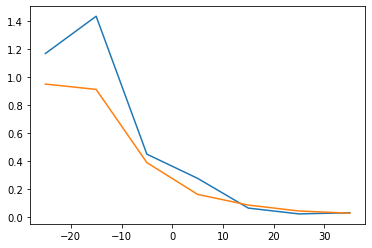

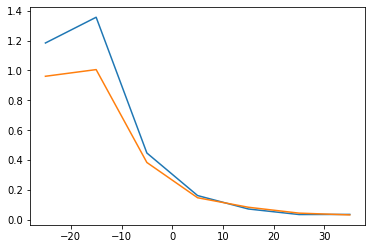

In [12]:
directory = '/work/data/trap_strength/'
filenames = [directory + 'strength1.txt',directory + 'strength2.txt',directory + 'strength3.txt',
    directory + 'strength4.txt',directory + 'strength5.txt',directory + 'strength6.txt',
    directory + 'strength7.txt',]
k_arr_strength_gauss = []
k_arr_strength_eqi = []
ND_arr = np.arange(-25,45,10) # ND marker in mm

for filename in filenames:
    ret = extract_data(filename)
    
    
    analysis2 = gaussian_analysis(ret.x_dec, ret.y_dec)
    
    k_arr_strength_gauss.append([analysis2.k_x, analysis2.k_y])
    k_x, k_y = get_k_equipartition(ret.x_dec, ret.y_dec)
    k_arr_strength_eqi.append([k_x,k_y])
    
plt.show()
    

k_arr_strength_gauss = np.array(k_arr_strength_gauss)
k_arr_strength_eqi = np.array(k_arr_strength_eqi)

plt.plot(ND_arr,k_arr_strength_gauss[:,0], label = '')
plt.plot(ND_arr,k_arr_strength_gauss[:,1])
plt.xlabel("ND Filter Location [mm from center]")
plt.ylabel(r"calculated k [pN/$\mu$m]")
plt.show()

plt.plot(ND_arr,k_arr_strength_eqi[:,0])
plt.plot(ND_arr,k_arr_strength_eqi[:,1])
plt.xlabel("ND Filter Location [mm from center]")
plt.ylabel(r"calculated k [pN/$\mu$m]")
plt.show()
plt.show()



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4bb45f9e-f9d7-4771-843d-2a6451217511' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>